# Training a Transformer for Sentiment Analysis
In this notebook, we fine-tune `DistilBERT` on a sentiment classification task with full visualization.

### Install Dependencies

In [1]:
!pip install transformers datasets torch matplotlib scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Load Required Libraries

In [2]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizer
from datasets import load_dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Dataset

In [4]:
# Load a small IMDb dataset from HuggingFace
dataset = load_dataset("imdb")
dataset["train"].train_test_split(test_size=0.2, stratify_by_column="label")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


### Exploratory Analysis on Data

In [5]:
train_data = dataset["train"]
test_data = dataset["test"]

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

print(df_train.head())

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


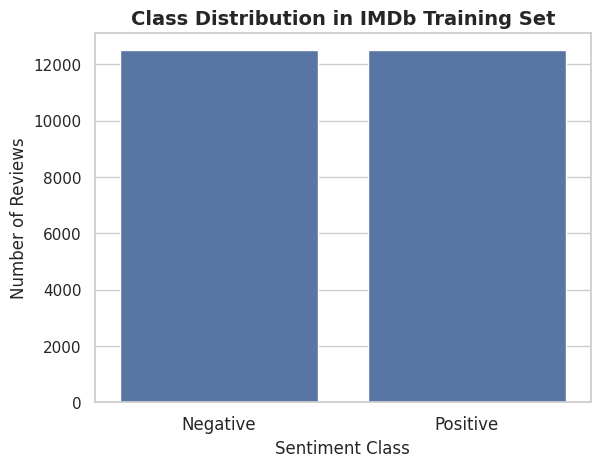

In [6]:
sns.set(style="whitegrid")
sns.countplot(x='label', data=df_train)
plt.xticks([0, 1], ['Negative', 'Positive'], fontsize=12)
plt.title("Class Distribution in IMDb Training Set", fontsize=14, weight='bold')
plt.xlabel("Sentiment Class", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)

plt.show()

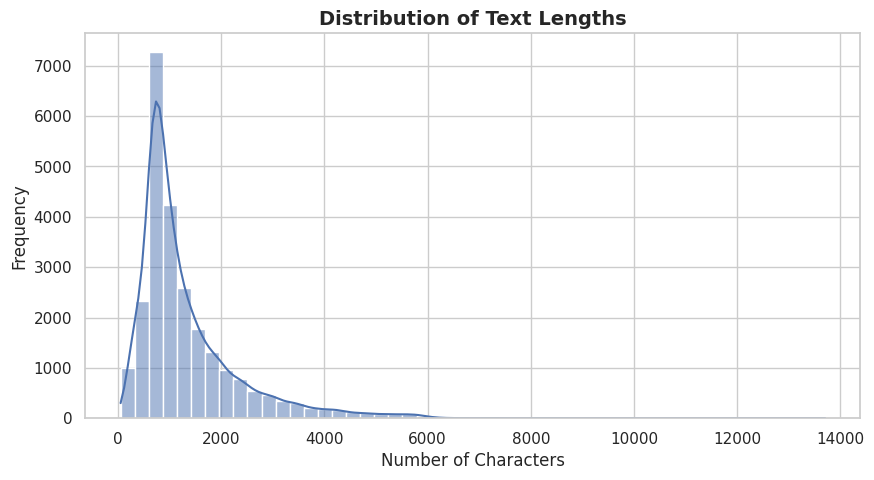

In [7]:
df_train['text_length'] = df_train['text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df_train['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Lengths", fontsize=14, weight='bold')
plt.xlabel("Number of Characters", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


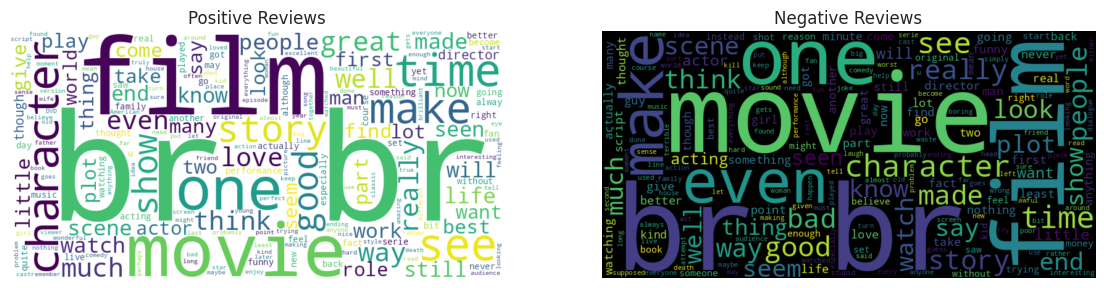

In [8]:
from wordcloud import WordCloud

positive_reviews = " ".join(df_train[df_train['label'] == 1]['text'].tolist())
negative_reviews = " ".join(df_train[df_train['label'] == 0]['text'].tolist())

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews")

plt.show()


### Tokenize the Text

In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Load Model

In [10]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define Metrics

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


### Train the Model

In [12]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [15]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.223300,0.290294,0.905680
2,0.170800,0.293409,0.926880
3,0.081800,0.347041,0.929440
4,0.000900,0.408936,0.931280


TrainOutput(global_step=12500, training_loss=0.1509554122025147, metrics={'train_runtime': 6164.1157, 'train_samples_per_second': 16.223, 'train_steps_per_second': 2.028, 'total_flos': 1.32467398656e+16, 'train_loss': 0.1509554122025147, 'epoch': 4.0})

### Evaluate & Visualize

Actual labels: (array([0, 1]), array([12500, 12500]))
Predicted labels: (array([0, 1]), array([12430, 12570]))


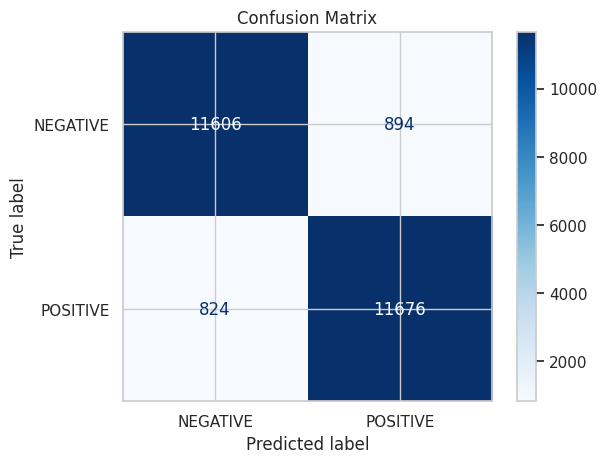

In [16]:
# Evaluate
preds = trainer.predict(tokenized_datasets["test"])
labels = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Print class distribution
print("Actual labels:", np.unique(labels, return_counts=True))
print("Predicted labels:", np.unique(y_pred, return_counts=True))

# Compute confusion matrix with explicit label ordering
# 0 = NEGATIVE, 1 = POSITIVE
cm = confusion_matrix(labels, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



### Save Model

In [17]:
trainer.save_model("/content/drive/MyDrive/my-distilbert-sentiment-model")
model.save_pretrained("/content/drive/MyDrive/my-transformer-model")
tokenizer.save_pretrained("/content/drive/MyDrive/my-transformer-model")

('/content/drive/MyDrive/my-transformer-model/tokenizer_config.json',
 '/content/drive/MyDrive/my-transformer-model/special_tokens_map.json',
 '/content/drive/MyDrive/my-transformer-model/vocab.txt',
 '/content/drive/MyDrive/my-transformer-model/added_tokens.json',
 '/content/drive/MyDrive/my-transformer-model/tokenizer.json')

In [18]:
model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/my-transformer-model")
tokenizer = DistilBertTokenizer.from_pretrained("/content/drive/MyDrive/my-transformer-model")

### Sentiment Analysis by fine tune Transformer with Hugging Face Pipeline


In [19]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cuda:0


In [20]:
# Define label mapping based on your training task
label_map = {
    "LABEL_0": "NEGATIVE",
    "LABEL_1": "POSITIVE"
}

# Get prediction
result = classifier("I hate the act but the person is good.")[0]
label = result['label']
score = result['score']

# Map to human-readable label
human_label = label_map.get(label, label)

print(f"Text: I hate the act but the person is good.")
print(f"Sentiment: {human_label} ({score:.2%} confidence)")

if human_label == "POSITIVE":
    print("✅ This is a POSITIVE statement.")
else:
    print("❌ This is a NEGATIVE statement.")

Text: I hate the act but the person is good.
Sentiment: POSITIVE (88.86% confidence)
✅ This is a POSITIVE statement.


       epoch    loss  eval_loss  eval_accuracy
0     0.0032  0.2299        NaN            NaN
1     0.0064  0.3396        NaN            NaN
2     0.0096  0.3304        NaN            NaN
3     0.0128  0.1626        NaN            NaN
4     0.0160  0.1801        NaN            NaN
...      ...     ...        ...            ...
1250  3.9936  0.1913        NaN            NaN
1251  3.9968  0.0005        NaN            NaN
1252  4.0000  0.0009        NaN            NaN
1253  4.0000     NaN   0.408936        0.93128
1254  4.0000     NaN        NaN            NaN

[1255 rows x 4 columns]


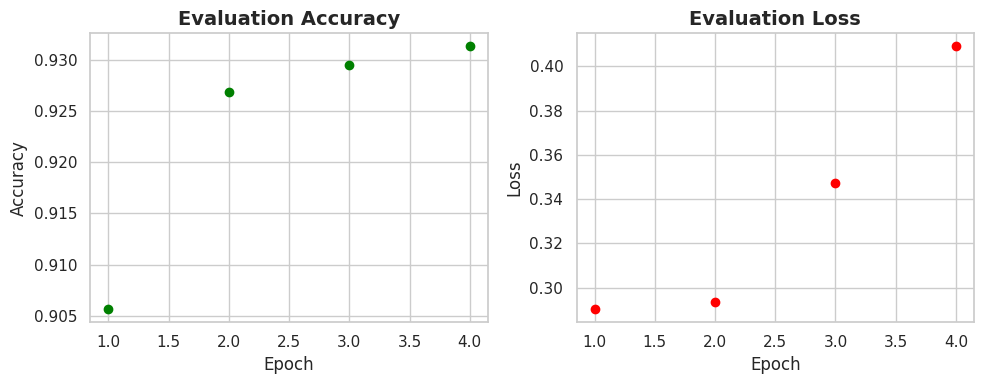

In [21]:
# Get training logs
log_history = trainer.state.log_history

# Convert to DataFrame
log_df = pd.DataFrame(log_history)

# Inspect Logs
print(log_df[['epoch', 'loss', 'eval_loss', 'eval_accuracy']])

# Filter rows with evaluation metrics
eval_df = log_df[log_df['epoch'].notna()]

# Plotting
plt.figure(figsize=(10, 4))

# Plot eval accuracy
plt.subplot(1, 2, 1)
plt.plot(eval_df['epoch'], eval_df['eval_accuracy'], marker='o', label='Eval Accuracy', color='green')
plt.title("Evaluation Accuracy", fontsize=14, weight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True)

# Plot eval loss
plt.subplot(1, 2, 2)
plt.plot(eval_df['epoch'], eval_df['eval_loss'], marker='o', label='Eval Loss', color='red')
plt.title("Evaluation Loss", fontsize=14, weight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()